# LightGBM 

This notebook will be used to tune and evaluate the LightGBM model

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, balanced_accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from pprint import pprint
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from utils.model_datatransforms import *

---
## Data Loading

In [3]:
df = pd.read_parquet('pred_model_data_full.parquet')

In [16]:
df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Unsupported                       20791
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Music non-amplified                 126
Nature elements - Wind              113
Name: noise_event_laeq_primary_detected_class, dtype: int64

Since we have fewer observations for 'Music non-amplified' and 'Nature elements - Wind', we will join these classes to 'Unsupported' 

In [4]:
conditions = df['noise_event_laeq_primary_detected_class'].isin(['Music non-amplified', 'Nature elements - Wind', 'Unsupported'])
df.loc[conditions, 'noise_event_laeq_primary_detected_class'] = 'Other'

df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Other                             21030
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [5]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class']) 

le = LabelEncoder()
y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Convert 'noise_event_laeq_primary_detected_certainty' to values between 0 and 1

In [6]:
X['noise_event_laeq_primary_detected_certainty']=X['noise_event_laeq_primary_detected_certainty']/100
X.noise_event_laeq_primary_detected_certainty

0        0.97
1        0.78
2        0.98
3        1.00
4        1.00
         ... 
77227    0.96
77228    0.98
77229    0.85
77230    0.00
77231    0.00
Name: noise_event_laeq_primary_detected_certainty, Length: 77232, dtype: float64

---
# Certainty + balanced_accuracy

In [73]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced'))
])

In [70]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.8206680810909059

In [74]:
#choose the parameters
n_estimators = np.arange(30,70,10)
learning_rate = np.array([0.05,0.1,0.15])
num_leaves = np.arange(20,60,10)
min_child_samples=np.arange(15,30,5)
eval_metric = ['mlogloss'] #'merror'

params_grid = {
    'month_handler__strategy': ['month'],#,'season'
    'day_of_the_week_handler__strategy': ['full'],#, 'weekend'
    'custom_encoder__strategy': ['one_hot', 'binary'],
    'lightgbm__n_estimators': n_estimators,
    'lightgbm__learning_rate': learning_rate,
    'lightgbm__num_leaves': num_leaves,
    'lightgbm__min_child_samples': min_child_samples,
    'lightgbm__eval_metric': eval_metric
}

In [75]:
cv = KFold(n_splits=3)
search = RandomizedSearchCV(pipeline, param_distributions=params_grid, n_jobs=-1, cv=cv, n_iter=250, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
#print("Best Estimator:", search.best_estimator_)
print("Best Parameters:", search.best_params_)

[LightGBM] [Warning] Unknown parameter: eval_metric
Best Score: 0.829504536992104
Best Parameters: {'month_handler__strategy': 'month', 'lightgbm__num_leaves': 20, 'lightgbm__n_estimators': 50, 'lightgbm__min_child_samples': 20, 'lightgbm__learning_rate': 0.1, 'lightgbm__eval_metric': 'mlogloss', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [7]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=20, n_estimators=50, min_child_samples=20, learning_rate=0.1, eval_metric='mlogloss'))
])

In [8]:
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: eval_metric


Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                                         'lamax_shift_t-_3', 'laeq_shift_t-_3',
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                       

In [78]:
y_pred = pipeline.predict(X_test)
#y_pred

In [79]:
y_pred_proba = pipeline.predict_proba(X_test)
#y_pred_proba

In [80]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

0.8240549232732921

In [81]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.9668549616435215

In [82]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

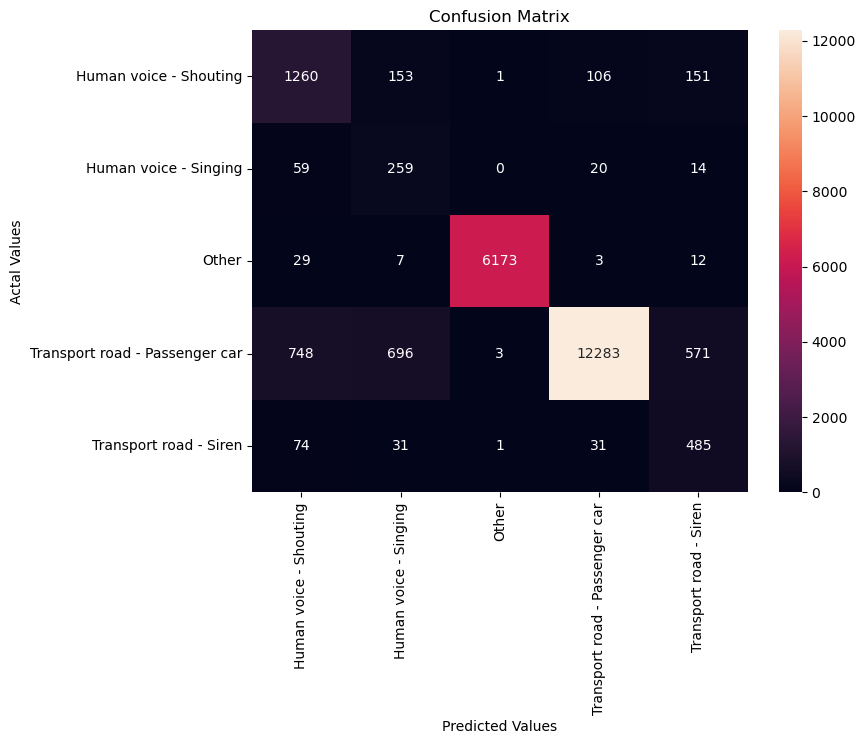

In [83]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')


plt.show()

In [84]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.58      0.75      0.66      1671
         Human voice - Singing       0.23      0.74      0.35       352
                         Other       1.00      0.99      1.00      6224
Transport road - Passenger car       0.99      0.86      0.92     14301
        Transport road - Siren       0.39      0.78      0.52       622

                      accuracy                           0.88     23170
                     macro avg       0.64      0.82      0.69     23170
                  weighted avg       0.93      0.88      0.90     23170



---
# Certainty + F1-weighted

In [127]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        #strategy='one_hot'
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced',n_estimators=400,learning_rate=0.2,num_leaves=30,min_child_samples=35,eval_metric='mlogloss'))
])

In [128]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.9488843321668655

In [129]:
#choose the parameters
n_estimators = np.arange(300,500,50)
learning_rate = np.array([0.1,0.2,0.3])
num_leaves = np.arange(20,60,10)
min_child_samples=np.arange(15,40,5)
eval_metric = ['mlogloss'] #'merror'

params_grid = {
    'month_handler__strategy': ['month'],#,'season'
    'day_of_the_week_handler__strategy': ['full'],#, 'weekend'
    'custom_encoder__strategy': ['one_hot', 'binary'],
    'lightgbm__n_estimators': n_estimators,
    'lightgbm__learning_rate': learning_rate,
    'lightgbm__num_leaves': num_leaves,
    'lightgbm__min_child_samples': min_child_samples,
    'lightgbm__eval_metric': eval_metric
}

In [130]:
cv = KFold(n_splits=3)
search = RandomizedSearchCV(pipeline, param_distributions=params_grid, n_jobs=-1, cv=cv, n_iter=400, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
#print("Best Estimator:", search.best_estimator_)
print("Best Parameters:", search.best_params_)

[LightGBM] [Warning] Unknown parameter: eval_metric
Best Score: 0.9490627432579277
Best Parameters: {'month_handler__strategy': 'month', 'lightgbm__num_leaves': 50, 'lightgbm__n_estimators': 350, 'lightgbm__min_child_samples': 30, 'lightgbm__learning_rate': 0.3, 'lightgbm__eval_metric': 'mlogloss', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [9]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=50, n_estimators=350, min_child_samples=30, learning_rate=0.3, eval_metric='mlogloss'))
])

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                       

In [133]:
y_pred = pipeline.predict(X_test)

In [134]:
y_pred_proba = pipeline.predict_proba(X_test)

In [135]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.953646957272335
Balanced Accuracy: 0.7723247723839965


In [136]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.9655949197074332

In [137]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

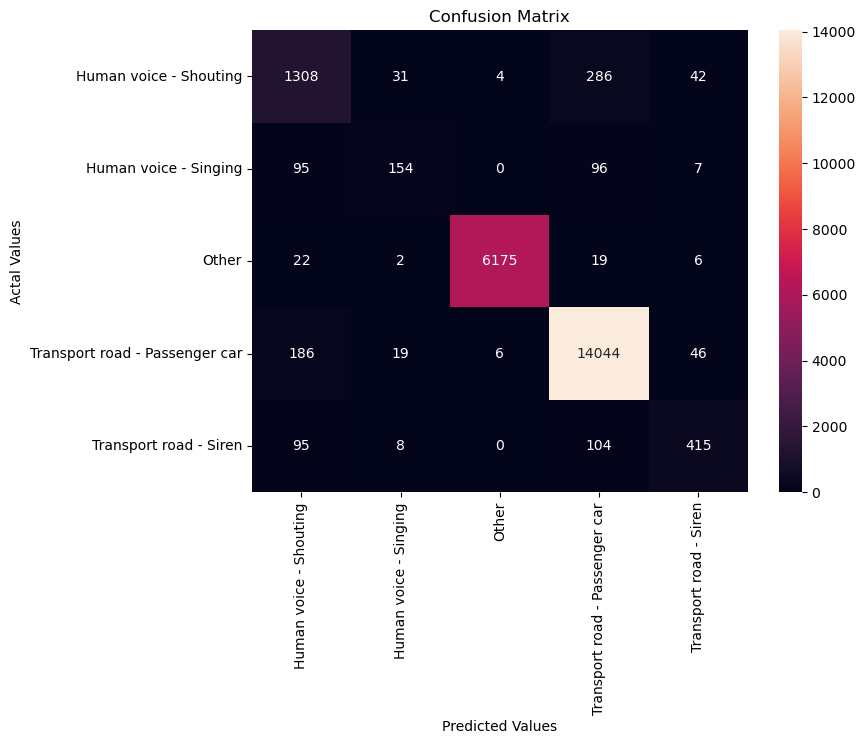

In [138]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.show()

In [139]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.77      0.78      0.77      1671
         Human voice - Singing       0.72      0.44      0.54       352
                         Other       1.00      0.99      1.00      6224
Transport road - Passenger car       0.97      0.98      0.97     14301
        Transport road - Siren       0.80      0.67      0.73       622

                      accuracy                           0.95     23170
                     macro avg       0.85      0.77      0.80     23170
                  weighted avg       0.95      0.95      0.95     23170



--- 
# No certainty + balanced_accuracy

We will drop the column 'noise_event_laeq_primary_detected_certainty'

In [207]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot'
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced'))
])

In [208]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.6288017743720041

In [209]:
#choose the parameters
n_estimators = np.arange(30,70,10)
learning_rate = np.array([0.11,0.13,0.15,0.17])
num_leaves = np.arange(18,26,2)
min_child_samples=np.arange(10,30,5)
eval_metric = ['mlogloss'] #'merror'

params_grid = {
    'month_handler__strategy': ['month'],#,'season'
    'day_of_the_week_handler__strategy': ['full'],#, 'weekend'
    'custom_encoder__strategy': ['one_hot'], #, 'binary'
    'lightgbm__n_estimators': n_estimators,
    'lightgbm__learning_rate': learning_rate,
    'lightgbm__num_leaves': num_leaves,
    'lightgbm__min_child_samples': min_child_samples,
    'lightgbm__eval_metric': eval_metric
}

In [210]:
cv = KFold(n_splits=3)
search = RandomizedSearchCV(pipeline, param_distributions=params_grid, n_jobs=-1, cv=cv, n_iter=200, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
#print("Best Estimator:", search.best_estimator_)
print("Best Parameters:", search.best_params_)

[LightGBM] [Warning] Unknown parameter: eval_metric
Best Score: 0.6429838021934451
Best Parameters: {'month_handler__strategy': 'month', 'lightgbm__num_leaves': 22, 'lightgbm__n_estimators': 40, 'lightgbm__min_child_samples': 20, 'lightgbm__learning_rate': 0.17, 'lightgbm__eval_metric': 'mlogloss', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [211]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot'
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=22, n_estimators=40, min_child_samples=20, learning_rate=0.17, eval_metric='mlogloss'))
])

In [212]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lamax_shift_t-_3', 'laeq_shift_t-_3',
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_s

In [213]:
y_pred = pipeline.predict(X_test)

In [214]:
y_pred_proba = pipeline.predict_proba(X_test)

In [215]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.660509279240397
Balanced Accuracy: 0.6463312702859417


In [216]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.8923844061048201

In [217]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

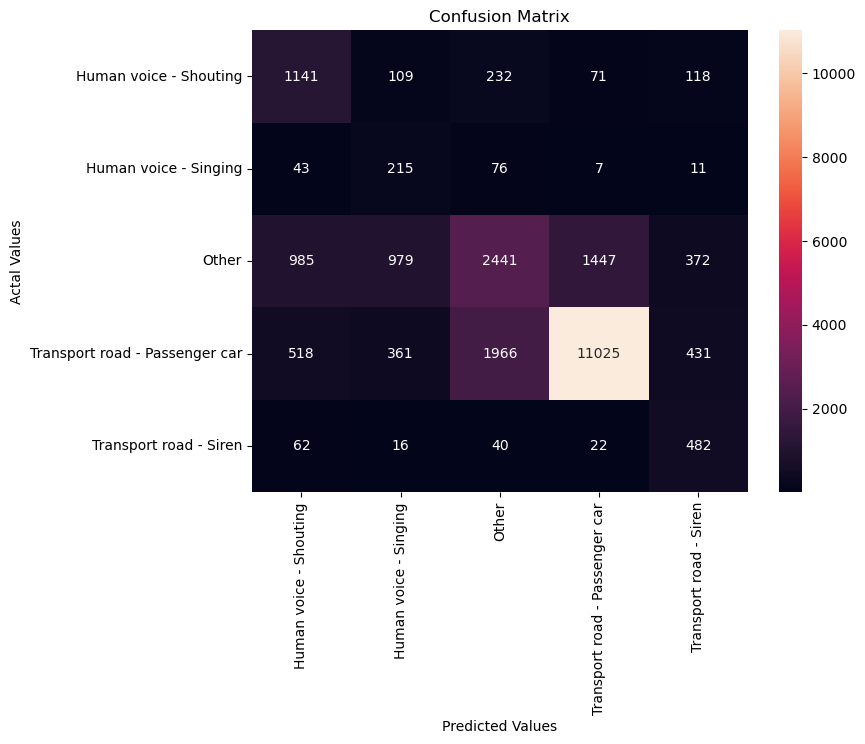

In [218]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

plt.show()

In [219]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.42      0.68      0.52      1671
         Human voice - Singing       0.13      0.61      0.21       352
                         Other       0.51      0.39      0.44      6224
Transport road - Passenger car       0.88      0.77      0.82     14301
        Transport road - Siren       0.34      0.77      0.47       622

                      accuracy                           0.66     23170
                     macro avg       0.45      0.65      0.49     23170
                  weighted avg       0.72      0.66      0.68     23170



---
# No certainty + F1-weighted

In [268]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot'
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced'))
])

In [260]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.7411170471158233

In [269]:
#choose the parameters
n_estimators = np.arange(400,700,100)
learning_rate = np.array([0.05,0.1,0.15])
num_leaves = np.arange(30,60,10)
min_child_samples=np.arange(20,40,5)
eval_metric = ['mlogloss'] #'merror'

params_grid = {
    'month_handler__strategy': ['month'],#,'season'
    'day_of_the_week_handler__strategy': ['full'],#, 'weekend'
    'custom_encoder__strategy': ['one_hot'],#, 'binary'
    'lightgbm__n_estimators': n_estimators,
    'lightgbm__learning_rate': learning_rate,
    'lightgbm__num_leaves': num_leaves,
    'lightgbm__min_child_samples': min_child_samples,
    'lightgbm__eval_metric': eval_metric
}

In [270]:
cv = KFold(n_splits=3)
search = RandomizedSearchCV(pipeline, param_distributions=params_grid, n_jobs=-1, cv=cv, n_iter=400, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
#print("Best Estimator:", search.best_estimator_)
print("Best Parameters:", search.best_params_)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 108 is smaller than n_iter=400. Running 108 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
Best Score: 0.745112068613825
Best Parameters: {'month_handler__strategy': 'month', 'lightgbm__num_leaves': 50, 'lightgbm__n_estimators': 600, 'lightgbm__min_child_samples': 25, 'lightgbm__learning_rate': 0.1, 'lightgbm__eval_metric': 'mlogloss', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [271]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot'
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=50, n_estimators=600, min_child_samples=25, learning_rate=0.1, eval_metric='mlogloss'))
])

In [272]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                         'lceq_shift_t-_5',
        

In [273]:
y_pred = pipeline.predict(X_test)

In [274]:
y_pred_proba = pipeline.predict_proba(X_test)

In [275]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.7535606387570134
Balanced Accuracy: 0.5587423521043817


In [276]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.8787909523572381

In [277]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

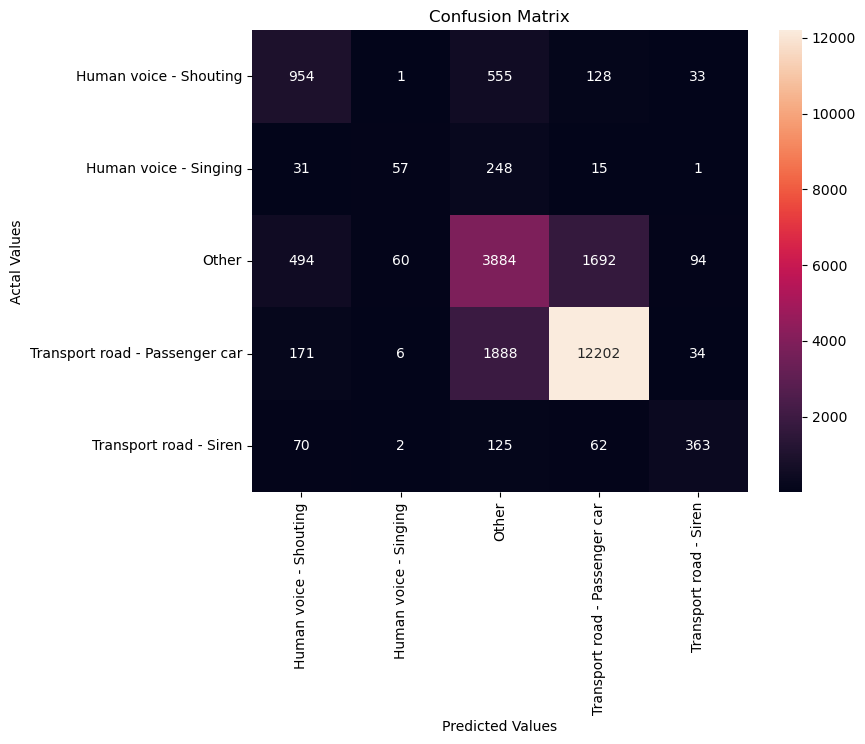

In [278]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')


plt.show()

In [279]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.55      0.57      0.56      1671
         Human voice - Singing       0.45      0.16      0.24       352
                         Other       0.58      0.62      0.60      6224
Transport road - Passenger car       0.87      0.85      0.86     14301
        Transport road - Siren       0.69      0.58      0.63       622

                      accuracy                           0.75     23170
                     macro avg       0.63      0.56      0.58     23170
                  weighted avg       0.76      0.75      0.75     23170



---
# Best Model

Model certainty + f1_weighted

In [7]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=50, n_estimators=350, min_child_samples=30, learning_rate=0.3, eval_metric='mlogloss'))
])

In [8]:
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: eval_metric


Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                       

Save the tuned and trained model with pickle

In [9]:
filename = 'best_model.sav'
pickle.dump(pipeline, open(filename, 'wb'))

Choose a sample of the test set for predictions in the app


In [ ]:
percentage = 0.25  # Change this to the desired percentage (e.g., 0.25 for 25%)
sampled_df = X_test.sample(frac=percentage, random_state=42)
sampled_df.to_csv('sampled_data.csv', index=False)